In [1]:
import os
import cv2
import glob
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings
from tensorflow.keras.layers import (Dense, Conv2D, MaxPooling2D, Activation, Dropout, Flatten, 
                                     BatchNormalization, AveragePooling2D, GlobalMaxPooling2D, Input, 
                                     Add, ZeroPadding2D)
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications import VGG16, VGG19, InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import preprocess_input
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [2]:
def get_files(directory):
    if not os.path.exists(directory):
        return 0
    count = 0
    # Crawls inside folders
    for current_path, dirs, files in os.walk(directory):
        for dr in dirs:
            count += len(glob.glob(os.path.join(current_path, dr + "/*")))
    return count

train_dir = r"C:\Users\HP\OneDrive\Desktop\images\train"
test_dir = r"C:\Users\HP\OneDrive\Desktop\images\test"
validation_dir = r"C:\Users\HP\OneDrive\Desktop\images\validation"
#to get tags
num_classes=len(glob.glob(train_dir+"/*")) 

print(num_classes,"Classes")
print("Number of files in train directory:", get_files(train_dir))
print("Number of files in test directory:", get_files(test_dir))


21 Classes
Number of files in train directory: 1729
Number of files in test directory: 558


In [3]:
# Create a data generator
train_datagen=ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
    )
test_datagen=ImageDataGenerator(rescale=1./255)

In [4]:
input_shape=(224,224,3)
# Create train and validation generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    shuffle=True,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)


Found 1729 images belonging to 21 classes.
Found 558 images belonging to 21 classes.


In [5]:
# Define the input shape
input_shape = (224, 224, 3)

# Initialize the model
model = Sequential([
    Input(shape=input_shape),
    Conv2D(32, (5, 5), activation='relu', name="conv2d_1"),
    MaxPooling2D(pool_size=(3, 3), name="max_pooling2d_1"),
    Conv2D(32, (3, 3), activation='relu', name="conv2d_2"),
    MaxPooling2D(pool_size=(2, 2), name="max_pooling2d_2"),
    Conv2D(64, (3, 3), activation='relu', name="conv2d_3"),
    MaxPooling2D(pool_size=(2, 2), name="max_pooling2d_3"),
    Flatten(name="flatten_1"),
    Dense(512, activation='relu'),
    Dropout(0.25),
    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax')
])

# Display model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)                    │ (None, 220, 220, 32)        │           2,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 73, 73, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 71, 71, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 35, 35, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 33, 33, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 16384)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       8,389,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 21)                  │           2,709 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,487,669 (32.38 MB)

 Trainable params: 8,487,669 (32.38 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
validation_generator = train_datagen.flow_from_directory(
                       test_dir,
                       target_size=(224, 224),
                       batch_size=32)

Found 558 images belonging to 21 classes.


In [7]:
# Suppress specific warning
warnings.filterwarnings("ignore", message=r"Your `PyDataset` class should call `super\(\)\.__init__\(\*\*kwargs\)`")

In [11]:
model.compile(optimizer='adam',loss = 'categorical_crossentropy',metrics=['accuracy'])
history1 = model.fit(
    train_generator,
    steps_per_epoch=None,
    epochs=2,
    validation_data=validation_generator,
    validation_steps=None,
    verbose=1,
    callbacks=[ReduceLROnPlateau(monitor='val_loss', factor=0.3,patience=3, min_lr=0.000001)],
    shuffle=True
    )

Epoch 1/2
55/55 ━━━━━━━━━━━━━━━━━━━━ 99s 2s/step - accuracy: 0.2727 - loss: 2.2936 - val_accuracy: 0.3871 - val_loss: 1.9030 - learning_rate: 0.0010
Epoch 2/2
55/55 ━━━━━━━━━━━━━━━━━━━━ 89s 1s/step - accuracy: 0.3923 - loss: 1.8505 - val_accuracy: 0.3100 - val_loss: 2.1973 - learning_rate: 0.0010


In [12]:
import os

# Ensure the directory exists
if not os.path.exists('Modelcrop'):
    os.makedirs('Modelcrop')

# Save the model to the 'Model' directory in the native Keras format
model.save('Modelcrop/plant_disease_Cnn.keras')
print("Model saved to the 'Model' directory in the native Keras format.")

Model saved to the 'Model' directory in the native Keras format.


In [12]:
# def create_Base_model_from_VGG16():  
#     model = VGG16(
#         weights = "imagenet",
#         include_top=False, 
#         input_shape = (224,224, 3) 
#         ) 
#     for layer in model.layers:
#       layer.trainable = False
#     return model 
# create_Base_model_from_VGG16().summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [13]:
# def add_custom_layers():
#     base_model = tf.keras.applications.VGG16(include_top=False, input_shape=(224, 224, 3))
#     x = base_model.output
#     x = tf.keras.layers.Flatten()(x)
#     x = tf.keras.layers.Dense(256, activation='relu')(x)
#     x = tf.keras.layers.Dropout(0.5)(x)
#     x = tf.keras.layers.Dense(num_classes, activation='softmax')(x)  
#     model = tf.keras.models.Model(inputs=base_model.input, outputs=x)
#     optimizer = Adam(learning_rate=0.001) 
#     model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
#     return model

# add_custom_layers().summary()


Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 256)                 │       6,422,784 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 21,142,869 (80.65 MB)

 Trainable params: 21,142,869 (80.65 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
validation_generator = train_datagen.flow_from_directory(
                       test_dir,
                       target_size=(224, 224),
                       batch_size=32)

Found 558 images belonging to 21 classes.


In [ ]:
model_from_vgg16 = add_custom_layers()
history2 = model_from_vgg16.fit(
    train_generator,
    steps_per_epoch=None,
    epochs=4,
    validation_data=validation_generator,
    validation_steps=None,
    verbose=1,
    callbacks=[ReduceLROnPlateau(monitor='val_loss', factor=0.3,patience=3, min_lr=0.000001)],
    shuffle=True
    )
# Epoch 1/3
# 55/55 ━━━━━━━━━━━━━━━━━━━━ 997s 18s/step - accuracy: 0.1643 - loss: 9.1086 - val_accuracy: 0.2079 - val_loss: 2.0603 - learning_rate: 0.0010
# Epoch 2/3
# 55/55 ━━━━━━━━━━━━━━━━━━━━ 1515s 27s/step - accuracy: 0.2043 - loss: 2.2040 - val_accuracy: 0.2079 - val_loss: 2.0560 - learning_rate: 0.0010
# Epoch 3/3
# 55/55 ━━━━━━━━━━━━━━━━━━━━ 1523s 28s/step - accuracy: 0.1831 - loss: 2.0676 - val_accuracy: 0.2079 - val_loss: 2.0071 - learning_rate: 0.0010

Epoch 1/4
55/55 ━━━━━━━━━━━━━━━━━━━━ 673s 12s/step - accuracy: 0.0536 - loss: 3.7574 - val_accuracy: 0.0287 - val_loss: 3.0771 - learning_rate: 0.0010
Epoch 2/4
55/55 ━━━━━━━━━━━━━━━━━━━━ 663s 12s/step - accuracy: 0.0540 - loss: 3.0253 - val_accuracy: 0.0466 - val_loss: 3.0287 - learning_rate: 0.0010
Epoch 3/4
55/55 ━━━━━━━━━━━━━━━━━━━━ 707s 13s/step - accuracy: 0.0717 - loss: 3.0246 - val_accuracy: 0.0394 - val_loss: 3.0459 - learning_rate: 0.0010
Epoch 4/4
 3/55 ━━━━━━━━━━━━━━━━━━━━ 10:22 12s/step - accuracy: 0.0417 - loss: 3.0442

In [ ]:
# Save the model to the 'Model' directory in the native Keras format
model_from_vgg16.save('Modelcrop/plant_disease_VGG16.keras')
print("Model saved to the current working directory.") 

In [14]:
def create_Base_model_from_VGG19():  
    model_vgg19 = VGG19(
        weights = "imagenet",# control point from which model is started
        include_top=False, # to include/exclude the first 3 layers
        input_shape = (224,224, 3)) # image size
    # don't train existing weights 
    for layer in model_vgg19.layers:
      layer.trainable = False
    return model_vgg19 
create_Base_model_from_VGG19().summary()

Model: "vgg19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 20,024,384 (76.39 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 20,024,384 (76.39 MB)

In [15]:
def add_custom_layers_vgg19():
    #Adding custom Layers 
    model_vgg19 = create_Base_model_from_VGG19()
    x = model_vgg19.output
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(256, activation="relu")(x)
    predictions = tf.keras.layers.Dense(num_classes, activation="softmax")(x)   
    # creating the final model 
    final_model = tf.keras.models.Model(
        inputs = model_vgg19.input, 
        outputs = predictions)
     
    final_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])  
    return final_model

add_custom_layers_vgg19().summary()

Model: "functional_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 26,452,565 (100.91 MB)

 Trainable params: 6,428,181 (24.52 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [16]:
validation_generator = train_datagen.flow_from_directory(
                       test_dir,
                       target_size=(224, 224),
                       batch_size=32)

Found 558 images belonging to 21 classes.


In [17]:
model_from_vgg19 = add_custom_layers_vgg19()
history3 = model_from_vgg19.fit(train_generator,
                      steps_per_epoch=None,
                      epochs=2,
                      validation_data=validation_generator,
                      validation_steps=None,
                      verbose=1,
                      callbacks=[ReduceLROnPlateau(monitor='val_loss', factor=0.3,patience=3, min_lr=0.000001)],
                      shuffle=True)

Epoch 1/2
55/55 ━━━━━━━━━━━━━━━━━━━━ 471s 8s/step - accuracy: 0.1984 - loss: 4.1515 - val_accuracy: 0.4462 - val_loss: 1.6786 - learning_rate: 0.0010
Epoch 2/2
55/55 ━━━━━━━━━━━━━━━━━━━━ 371s 7s/step - accuracy: 0.5818 - loss: 1.3335 - val_accuracy: 0.5609 - val_loss: 1.2724 - learning_rate: 0.0010


In [18]:
# Save the model to the 'Model' directory in the native Keras format
model_from_vgg19.save('Modelcrop/plant_disease_VGG19.keras')
print("Model saved to the current working directory.")

Model saved to the current working directory.


In [19]:
IMAGE_SIZE = [224, 224]
inception = InceptionV3(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)
# We don't need to train existing weights
for layer in inception.layers:
    layer.trainable = False

In [115]:
# Model layers -> can add more if required
x = Flatten()(inception.output)
prediction = Dense(num_classes, activation='softmax')(x)
# Create a model object
model_inception= Model(inputs=inception.input, outputs=prediction)
# View the structure of the model
model_inception.summary()

Model: "functional_403"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)    │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d (Conv2D)               │ (None, 111, 111, 32)      │             864 │ input_layer_4[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization           │ (None, 111, 111, 32)      │              96 │ conv2d[0][0]               │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation (Activation)       │ (None, 111, 111, 32)      │               0 │ batch_normalization[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_1 (Conv2D)             │ (None, 109, 109, 32)      │           9,216 │ activation[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_1         │ (None, 109, 109, 32)      │              96 │ conv2d_1[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_1 (Activation)     │ (None, 109, 109, 32)      │               0 │ batch_normalization_1[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_2 (Conv2D)             │ (None, 109, 109, 64)      │          18,432 │ activation_1[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_2         │ (None, 109, 109, 64)      │             192 │ conv2d_2[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_2 (Activation)     │ (None, 109, 109, 64)      │               0 │ batch_normalization_2[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d (MaxPooling2D)  │ (None, 54, 54, 64)        │               0 │ activation_2[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_3 (Conv2D)             │ (None, 54, 54, 80)        │           5,120 │ max_pooling2d[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_3         │ (None, 54, 54, 80)        │             240 │ conv2d_3[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_3 (Activation)     │ (None, 54, 54, 80)        │               0 │ batch_normalization_3[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_4 (Conv2D)             │ (None, 52, 52, 192)       │         138,240 │ activation_3[0][0]         │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 22,878,005 (87.27 MB)

 Trainable params: 1,075,221 (4.10 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [116]:
validation_generator = train_datagen.flow_from_directory(
                       test_dir,
                       target_size=(224, 224),
                       batch_size=32)

Found 558 images belonging to 21 classes.


In [119]:
# Defining the cost and model optimization method to use
model_inception.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
history4 = model_inception.fit(
    train_generator,
    steps_per_epoch=None,
    epochs=2,
    validation_data=validation_generator,
    validation_steps=None,
    verbose=1,
    callbacks=[ReduceLROnPlateau(monitor='val_loss', factor=0.3,patience=3, min_lr=0.000001)],
    shuffle=True)

Epoch 1/2
55/55 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - accuracy: 0.6698 - loss: 4.2593 - val_accuracy: 0.6039 - val_loss: 6.2461 - learning_rate: 0.0010
Epoch 2/2
55/55 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step - accuracy: 0.7404 - loss: 3.5683 - val_accuracy: 0.7240 - val_loss: 3.9625 - learning_rate: 0.0010


In [120]:
# Save the model to the 'Model' directory in the native Keras format
model_inception.save('Modelcrop/plant_disease_inception.keras')
print("Model saved to the current working directory.")

Model saved to the current working directory.


In [121]:
print("[INFO] Calculating model accuracy")
scores = model_inception.evaluate(validation_generator)
print(f"Test Accuracy: {scores[1]*100}")

[INFO] Calculating model accuracy
18/18 ━━━━━━━━━━━━━━━━━━━━ 14s 761ms/step - accuracy: 0.7343 - loss: 3.7482
Test Accuracy: 70.78853249549866


In [25]:
# Importing Keras libraries and packages
from keras.models import Sequential
from keras.layers import Convolution2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import BatchNormalization

In [27]:
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D, BatchNormalization, Flatten, Dense, Dropout, Input

# Initializing the CNN
model_alexnet = Sequential()

# Input layer with the specified shape
model_alexnet.add(Input(shape=(224, 224, 3)))

# Convolution Step 1
model_alexnet.add(Convolution2D(96, 11, strides=(4, 4), padding='valid', activation='relu'))
# Max Pooling Step 1
model_alexnet.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))
model_alexnet.add(BatchNormalization())

# Convolution Step 2
model_alexnet.add(Convolution2D(256, 11, strides=(1, 1), padding='valid', activation='relu'))
# Max Pooling Step 2
model_alexnet.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))
model_alexnet.add(BatchNormalization())

# Convolution Step 3
model_alexnet.add(Convolution2D(384, 3, strides=(1, 1), padding='valid', activation='relu'))
model_alexnet.add(BatchNormalization())

# Convolution Step 4
model_alexnet.add(Convolution2D(384, 3, strides=(1, 1), padding='valid', activation='relu'))
model_alexnet.add(BatchNormalization())

# Convolution Step 5
model_alexnet.add(Convolution2D(256, 3, strides=(1, 1), padding='valid', activation='relu'))
# Max Pooling Step 3
model_alexnet.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))
model_alexnet.add(BatchNormalization())

# Flattening Step
model_alexnet.add(Flatten())

# Full Connection Step
model_alexnet.add(Dense(units=4096, activation='relu'))
model_alexnet.add(Dropout(0.4))
model_alexnet.add(BatchNormalization())
model_alexnet.add(Dense(units=4096, activation='relu'))
model_alexnet.add(Dropout(0.4))
model_alexnet.add(BatchNormalization())
model_alexnet.add(Dense(units=1000, activation='relu'))
model_alexnet.add(Dropout(0.2))
model_alexnet.add(BatchNormalization())
model_alexnet.add(Dense(units=num_classes, activation='softmax'))

# Summary of the model
model_alexnet.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_99 (Conv2D)                   │ (None, 54, 54, 96)          │          34,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 27, 27, 96)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_102              │ (None, 27, 27, 96)          │             384 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_100 (Conv2D)                  │ (None, 17, 17, 256)         │       2,973,952 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_103              │ (None, 8, 8, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_101 (Conv2D)                  │ (None, 6, 6, 384)           │         885,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_104              │ (None, 6, 6, 384)           │           1,536 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_102 (Conv2D)                  │ (None, 4, 4, 384)           │       1,327,488 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_105              │ (None, 4, 4, 384)           │           1,536 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_103 (Conv2D)                  │ (None, 2, 2, 256)           │         884,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 1, 1, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_106              │ (None, 1, 1, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 4096)                │       1,052,672 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_107              │ (None, 4096)                │          16,384 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 4096)                │      16,781,312 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 28,100,773 (107.20 MB)

 Trainable params: 28,079,637 (107.12 MB)

 Non-trainable params: 21,136 (82.56 KB)

In [28]:
validation_generator = train_datagen.flow_from_directory(
                       test_dir,
                       target_size=(224, 224),
                       batch_size=32)

Found 558 images belonging to 21 classes.


In [50]:
# model_alexnet.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# # Calculate steps_per_epoch based on the size of your training dataset
# steps_per_epoch = len(train_generator) // train_generator.batch_size
# # Calculate validation_steps based on the size of your validation dataset
# validation_steps = len(validation_generator) // validation_generator.batch_size
# history5 = model_alexnet.fit(
#     train_generator,
#     steps_per_epoch=steps_per_epoch,
#     epochs=10,
#     validation_data=validation_generator,
#     validation_steps=validation_steps,
#     verbose=1,
#     callbacks=[ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, min_lr=0.000001)],
#     shuffle=True
# )

model_alexnet.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
history = model_alexnet.fit(    
    train_generator,
    steps_per_epoch=None,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=4,
    verbose=1,
    callbacks=[ReduceLROnPlateau(monitor='val_loss', factor=0.3,patience=3, min_lr=0.000001)],
    shuffle=True)

Epoch 1/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step - accuracy: 0.1966 - loss: 3.1314 - val_accuracy: 0.1250 - val_loss: 72.3738 - learning_rate: 0.0010
Epoch 2/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.2976 - loss: 2.3119 - val_accuracy: 0.1641 - val_loss: 11.3519 - learning_rate: 0.0010
Epoch 3/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.3123 - loss: 2.2109 - val_accuracy: 0.1953 - val_loss: 13.6215 - learning_rate: 0.0010
Epoch 4/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 64s 1s/step - accuracy: 0.3186 - loss: 2.1947 - val_accuracy: 0.1172 - val_loss: 19.0603 - learning_rate: 0.0010
Epoch 5/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - accuracy: 0.3223 - loss: 2.1340 - val_accuracy: 0.1087 - val_loss: 12.8415 - learning_rate: 0.0010
Epoch 6/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 64s 1s/step - accuracy: 0.3721 - loss: 1.8977 - val_accuracy: 0.1719 - val_loss: 5.2672 - learning_rate: 3.0000e-04
Epoch 7/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 64s 1s/step - accuracy: 0.4132 - loss: 1.7464 - val_a

In [51]:
# Save the model to the 'Model' directory in the native Keras format
model_alexnet.save('Modelcrop/model_AlexNet.keras')
print("Model saved to the current working directory.")

Model saved to the current working directory.


In [52]:
print("[INFO] Calculating model accuracy")
scores = model_alexnet.evaluate(validation_generator)
print(f"Validation Loss: {scores[0]}")
print(f"Validation Accuracy: {scores[1]*100:.2f}%")

[INFO] Calculating model accuracy
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 391ms/step - accuracy: 0.3240 - loss: 2.6720
Validation Loss: 2.694162130355835
Validation Accuracy: 33.87%


In [53]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 558 images belonging to 21 classes.


In [56]:
results = model_alexnet.evaluate(test_generator, verbose=1)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 210ms/step - accuracy: 0.3520 - loss: 2.6597
    Test Loss: 2.75171
Test Accuracy: 33.15%


In [57]:
# Predict the label of the test_gen
pred = model.predict(test_generator,verbose=1)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

18/18 ━━━━━━━━━━━━━━━━━━━━ 12s 644ms/step


In [58]:
from sklearn.metrics import classification_report
import numpy as np

# Get true labels
y_true = test_generator.classes  # True labels
class_indices = test_generator.class_indices  # Class indices mapping
class_labels = list(class_indices.keys())  # Class labels

# Make predictions
predictions = model_alexnet.predict(test_generator, verbose=1)
y_pred = np.argmax(predictions, axis=1)  # Convert predictions to class indices

# Print the classification report
print(classification_report(y_true, y_pred, target_names=class_labels, zero_division=0))

18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 259ms/step
                            precision    recall  f1-score   support

            Rice_BrownSpot       0.00      0.00      0.00        32
              Rice_Healthy       0.00      0.00      0.00        33
            Rice_LeafBlast       0.06      0.13      0.08        31
        Strawberry_healthy       0.00      0.00      0.00        21
    Strawberry_leaf_scorch       0.00      0.00      0.00        24
     Tomato_bacterial_spot       0.07      0.03      0.04        36
       Tomato_early_blight       0.09      0.14      0.11        29
            Tomato_healthy       0.02      0.03      0.03        30
        Tomato_late_blight       0.00      0.00      0.00        21
          apple_cedar_rust       0.12      0.07      0.09        27
             apple_healthy       0.04      0.09      0.06        35
                apple_scab       0.02      0.04      0.03        25
            cherry_healthy       0.00      0.00      0.00        16
     c

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss', 'learning_rate'])


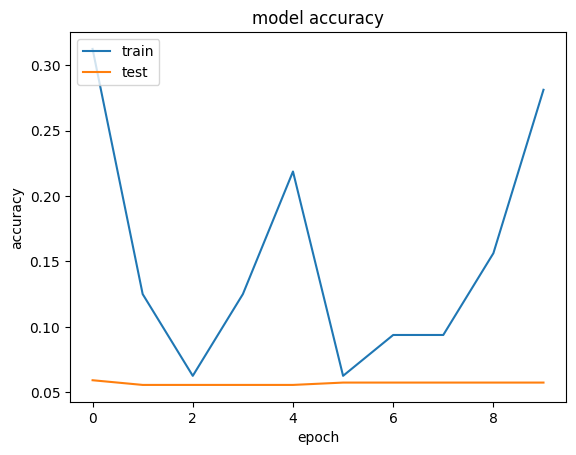

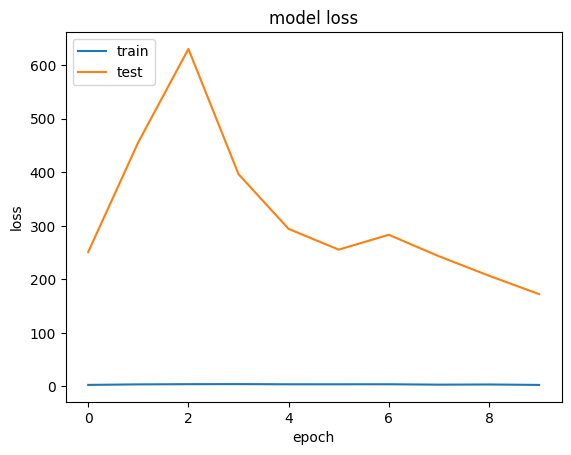

In [59]:
from keras.models import Sequential
from keras.layers import Dense
import matplotlib.pyplot as plt
import numpy

print(history5.history.keys())

plt.plot(history5.history['accuracy'])
plt.plot(history5.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history5.history['loss'])
plt.plot(history5.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [60]:
from tensorflow.keras.applications import ResNet50

In [61]:
pretrained_model = ResNet50(
    input_shape=(224,224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
pretrained_model.trainable = False

In [62]:
inputs = pretrained_model.input

x = Dense(128, activation='relu')(pretrained_model.output)
x = Dense(128, activation='relu')(x)

outputs = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

In [63]:
from tensorflow.keras.callbacks import EarlyStopping

In [64]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
my_callbacks  = [EarlyStopping(monitor='val_loss',min_delta=0,patience=3,mode='auto')]

In [65]:
validation_generator= test_datagen.flow_from_directory(
    validation_dir,
    shuffle=True,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 724 images belonging to 21 classes.


In [67]:
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10,
    callbacks=my_callbacks,
    verbose=1,
    steps_per_epoch=None,
    validation_steps=4
)

Epoch 1/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.1038 - loss: 2.8072 - val_accuracy: 0.1094 - val_loss: 2.7515
Epoch 2/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - accuracy: 0.1288 - loss: 2.7431 - val_accuracy: 0.1328 - val_loss: 2.5990
Epoch 3/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 88s 2s/step - accuracy: 0.1205 - loss: 2.7650 - val_accuracy: 0.1562 - val_loss: 2.6159
Epoch 4/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 87s 2s/step - accuracy: 0.1771 - loss: 2.6696 - val_accuracy: 0.1562 - val_loss: 2.8003
Epoch 5/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 88s 2s/step - accuracy: 0.1551 - loss: 2.6655 - val_accuracy: 0.2031 - val_loss: 2.6342


In [68]:
# Save the model to the 'Model' directory in the native Keras format
model.save('Modelcrop/model_resnet50.keras')
print("Model saved to the current working directory.")

Model saved to the current working directory.


In [69]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(validation_generator)
print(f"Test Accuracy: {scores[1]*100}")

[INFO] Calculating model accuracy
23/23 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.1726 - loss: 2.6520
Test Accuracy: 18.370166420936584


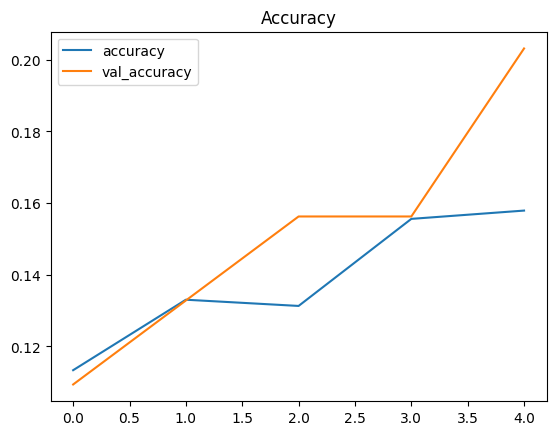

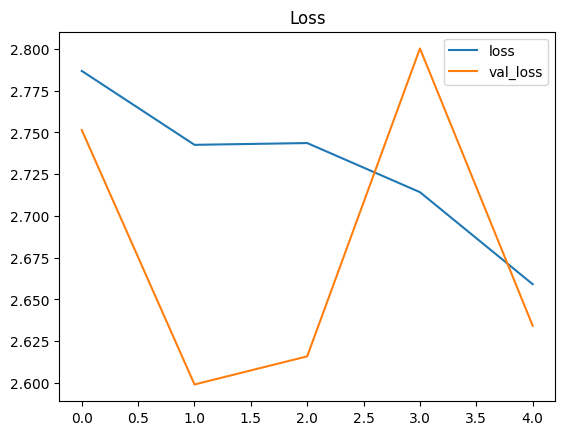

In [70]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [71]:
# OneDrive/Desktop/images/validation/apple/healthy/0a02e8cb-b715-497f-a16a-c28b3409f927___RS_HL 7432.JPG
# from keras.models import load_model
# # Load the model from the native Keras format
# model = load_model('Model/plant_disease_Cnn.keras')

In [72]:
import numpy as np
from keras.models import load_model
from keras.preprocessing import image
import matplotlib.pyplot as plt

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


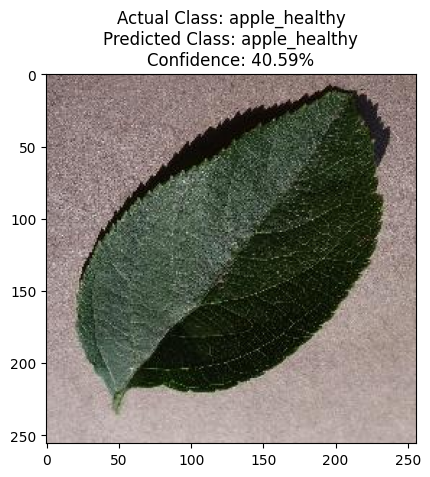

Actual Class: apple_healthy
Predicted Class: apple_healthy
Prediction Confidence: 40.59%


In [87]:
# Load the pre-trained model
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

# Load the pre-trained model
model = load_model('Modelcrop/plant_disease_Cnn.keras')

# Define the classes based on your training data
classes = list(train_generator.class_indices.keys())

# Function to preprocess the image
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))  
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  
    return img_array

# Load and preprocess the image
img_path = 'OneDrive/Desktop/images/validation/apple_healthy/1d7c71d2-fac0-4ee6-8def-765282cb744c___RS_HL 5758.JPG'
actual_class = 'apple_healthy'  # Specify the actual class here

preprocessed_image = preprocess_image(img_path)

# Predict the class of the image
prediction = model.predict(preprocessed_image)
predicted_class_index = np.argmax(prediction, axis=1)[0]
predicted_class = classes[predicted_class_index]

# Display the image along with the predicted and actual class
plt.imshow(image.load_img(img_path))
plt.title(f"Actual Class: {actual_class}\nPredicted Class: {predicted_class}\nConfidence: {prediction[0][predicted_class_index] * 100:.2f}%", fontsize=12)
plt.show()

print(f"Actual Class: {actual_class}")
print(f"Predicted Class: {predicted_class}")
print(f"Prediction Confidence: {prediction[0][predicted_class_index] * 100:.2f}%")




In [75]:
# # Load the pre-trained model
# model = load_model('Modelcrop/plant_disease_VGG16.keras')

# # Define the classes based on your training data
# classes=list(train_generator.class_indices.keys())

# # Function to preprocess the image
# def preprocess_image(img_path):
#     img = image.load_img(img_path, target_size=(224, 224))  
#     img_array = image.img_to_array(img)
#     img_array = np.expand_dims(img_array, axis=0)
#     img_array /= 255.0  
#     return img_array

# # Load and preprocess the image
# #img_path = 'OneDrive/Desktop/images/validation/apple/healthy/0a02e8cb-b715-497f-a16a-c28b3409f927___RS_HL 7432.JPG'
# img_path = 'OneDrive/Desktop/images/validation/apple/healthy/77004cfa-f435-49af-8435-7986927228ca___RS_HL 7609.JPG'
# preprocessed_image = preprocess_image(img_path)

# # Predict the class of the image
# prediction = model.predict(preprocessed_image)
# predicted_class_index = np.argmax(prediction, axis=1)[0]
# predicted_class = classes[predicted_class_index]

# plt.imshow(image.load_img(img_path))
# plt.title(f"Predicted Class: {predicted_class}\nConfidence: {prediction[0][predicted_class_index] * 100:.2f}%", fontsize=12)
# plt.show()

# print(f"Predicted Class: {predicted_class}")
# print(f"Prediction Confidence: {prediction[0][predicted_class_index] * 100:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step


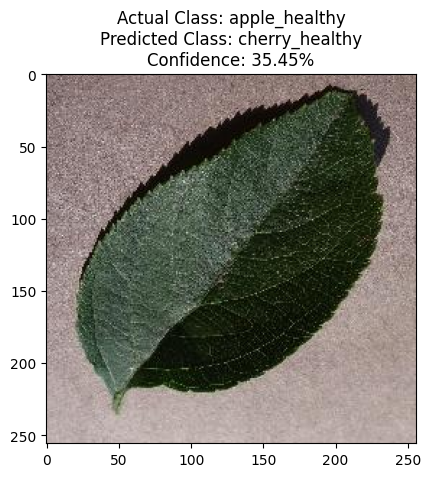

Actual Class: apple_healthy
Predicted Class: cherry_healthy
Prediction Confidence: 35.45%


In [86]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

# Load the pre-trained model
model = load_model('Modelcrop/plant_disease_VGG19.keras')

# Define the classes based on your training data
classes = list(train_generator.class_indices.keys())

# Function to preprocess the image
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))  
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  
    return img_array

# Load and preprocess the image
img_path = 'OneDrive/Desktop/images/validation/apple_healthy/1d7c71d2-fac0-4ee6-8def-765282cb744c___RS_HL 5758.JPG'
actual_class = 'apple_healthy'  # Specify the actual class here

preprocessed_image = preprocess_image(img_path)

# Predict the class of the image
prediction = model.predict(preprocessed_image)
predicted_class_index = np.argmax(prediction, axis=1)[0]
predicted_class = classes[predicted_class_index]

# Display the image along with the predicted and actual class
plt.imshow(image.load_img(img_path))
plt.title(f"Actual Class: {actual_class}\nPredicted Class: {predicted_class}\nConfidence: {prediction[0][predicted_class_index] * 100:.2f}%", fontsize=12)
plt.show()

print(f"Actual Class: {actual_class}")
print(f"Predicted Class: {predicted_class}")
print(f"Prediction Confidence: {prediction[0][predicted_class_index] * 100:.2f}%")



1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


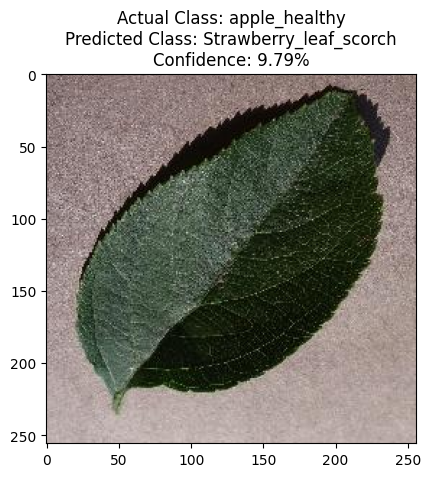

Actual Class: apple_healthy
Predicted Class: Strawberry_leaf_scorch
Prediction Confidence: 9.79%


In [112]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

# Load the pre-trained model
model = load_model('Modelcrop/model_resnet50.keras')

# Define the classes based on your training data
classes = list(train_generator.class_indices.keys())

# Function to preprocess the image
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))  
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  
    return img_array

# Load and preprocess the image
img_path = 'OneDrive/Desktop/images/validation/apple_healthy/1d7c71d2-fac0-4ee6-8def-765282cb744c___RS_HL 5758.JPG'
actual_class = 'apple_healthy'  # Specify the actual class here

preprocessed_image = preprocess_image(img_path)

# Predict the class of the image
prediction = model.predict(preprocessed_image)
predicted_class_index = np.argmax(prediction, axis=1)[0]
predicted_class = classes[predicted_class_index]

# Display the image along with the predicted and actual class
plt.imshow(image.load_img(img_path))
plt.title(f"Actual Class: {actual_class}\nPredicted Class: {predicted_class}\nConfidence: {prediction[0][predicted_class_index] * 100:.2f}%", fontsize=12)
plt.show()

print(f"Actual Class: {actual_class}")
print(f"Predicted Class: {predicted_class}")
print(f"Prediction Confidence: {prediction[0][predicted_class_index] * 100:.2f}%")


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


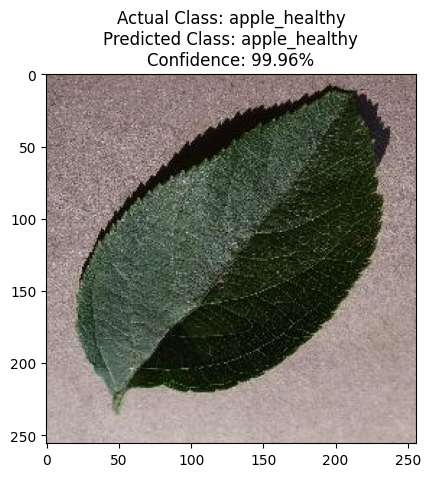

Actual Class: apple_healthy
Predicted Class: apple_healthy
Prediction Confidence: 99.96%


In [81]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

# Load the pre-trained model
model = load_model('Modelcrop/plant_disease_inception.keras')

# Define the classes based on your training data
classes = list(train_generator.class_indices.keys())

# Function to preprocess the image
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))  
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  
    return img_array

# Load and preprocess the image
img_path = 'OneDrive/Desktop/images/validation/apple_healthy/1d7c71d2-fac0-4ee6-8def-765282cb744c___RS_HL 5758.JPG'
actual_class = 'apple_healthy'  # Specify the actual class here

preprocessed_image = preprocess_image(img_path)

# Predict the class of the image
prediction = model.predict(preprocessed_image)
predicted_class_index = np.argmax(prediction, axis=1)[0]
predicted_class = classes[predicted_class_index]

# Display the image along with the predicted and actual class
plt.imshow(image.load_img(img_path))
plt.title(f"Actual Class: {actual_class}\nPredicted Class: {predicted_class}\nConfidence: {prediction[0][predicted_class_index] * 100:.2f}%", fontsize=12)
plt.show()

print(f"Actual Class: {actual_class}")
print(f"Predicted Class: {predicted_class}")
print(f"Prediction Confidence: {prediction[0][predicted_class_index] * 100:.2f}%")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


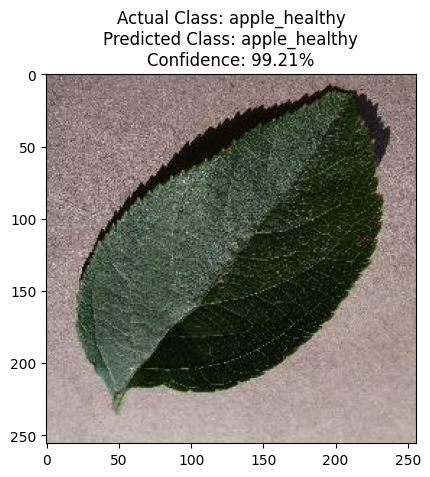

Actual Class: apple_healthy
Predicted Class: apple_healthy
Prediction Confidence: 99.21%


In [85]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

# Load the pre-trained model
model = load_model('Modelcrop/model_AlexNet.keras')

# Define the classes based on your training data
classes = list(train_generator.class_indices.keys())

# Function to preprocess the image
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))  
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  
    return img_array

# Load and preprocess the image
img_path = 'OneDrive/Desktop/images/validation/apple_healthy/1d7c71d2-fac0-4ee6-8def-765282cb744c___RS_HL 5758.JPG'
actual_class = 'apple_healthy'  # Specify the actual class here

preprocessed_image = preprocess_image(img_path)

# Predict the class of the image
prediction = model.predict(preprocessed_image)
predicted_class_index = np.argmax(prediction, axis=1)[0]
predicted_class = classes[predicted_class_index]

# Display the image along with the predicted and actual class
plt.imshow(image.load_img(img_path))
plt.title(f"Actual Class: {actual_class}\nPredicted Class: {predicted_class}\nConfidence: {prediction[0][predicted_class_index] * 100:.2f}%", fontsize=12)
plt.show()

print(f"Actual Class: {actual_class}")
print(f"Predicted Class: {predicted_class}")
print(f"Prediction Confidence: {prediction[0][predicted_class_index] * 100:.2f}%")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


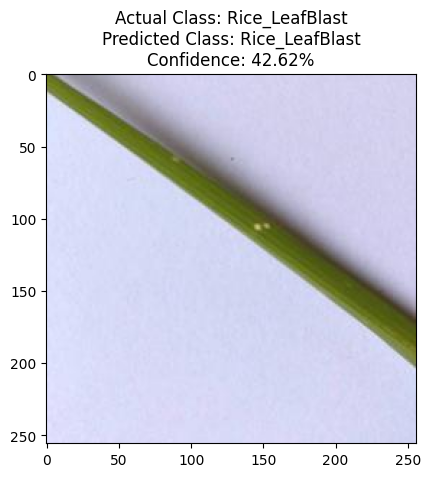

Actual Class: Rice_LeafBlast
Predicted Class: Rice_LeafBlast
Prediction Confidence: 42.62%


In [88]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

# Load the pre-trained model
model = load_model('Modelcrop/plant_disease_Cnn.keras')

# Define the classes based on your training data
classes = list(train_generator.class_indices.keys())

# Function to preprocess the image
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))  
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  
    return img_array

# Load and preprocess the image
img_path = 'OneDrive/Desktop/images/validation/Rice_LeafBlast/shape 199 .jpg'
actual_class = 'Rice_LeafBlast'  # Specify the actual class here

preprocessed_image = preprocess_image(img_path)

# Predict the class of the image
prediction = model.predict(preprocessed_image)
predicted_class_index = np.argmax(prediction, axis=1)[0]
predicted_class = classes[predicted_class_index]

# Display the image along with the predicted and actual class
plt.imshow(image.load_img(img_path))
plt.title(f"Actual Class: {actual_class}\nPredicted Class: {predicted_class}\nConfidence: {prediction[0][predicted_class_index] * 100:.2f}%", fontsize=12)
plt.show()

print(f"Actual Class: {actual_class}")
print(f"Predicted Class: {predicted_class}")
print(f"Prediction Confidence: {prediction[0][predicted_class_index] * 100:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step


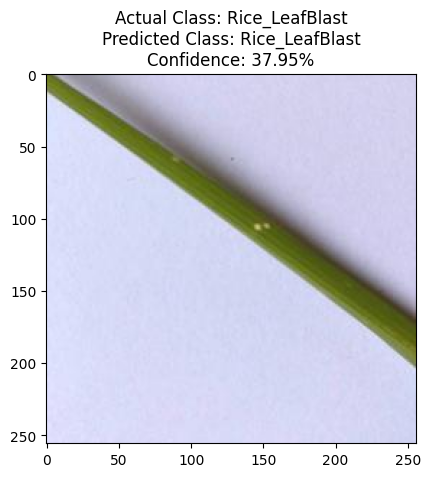

Actual Class: Rice_LeafBlast
Predicted Class: Rice_LeafBlast
Prediction Confidence: 37.95%


In [89]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

# Load the pre-trained model
model = load_model('Modelcrop/plant_disease_VGG19.keras')

# Define the classes based on your training data
classes = list(train_generator.class_indices.keys())

# Function to preprocess the image
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))  
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  
    return img_array

# Load and preprocess the image
img_path = 'OneDrive/Desktop/images/validation/Rice_LeafBlast/shape 199 .jpg'
actual_class = 'Rice_LeafBlast'  # Specify the actual class here

preprocessed_image = preprocess_image(img_path)

# Predict the class of the image
prediction = model.predict(preprocessed_image)
predicted_class_index = np.argmax(prediction, axis=1)[0]
predicted_class = classes[predicted_class_index]

# Display the image along with the predicted and actual class
plt.imshow(image.load_img(img_path))
plt.title(f"Actual Class: {actual_class}\nPredicted Class: {predicted_class}\nConfidence: {prediction[0][predicted_class_index] * 100:.2f}%", fontsize=12)
plt.show()

print(f"Actual Class: {actual_class}")
print(f"Predicted Class: {predicted_class}")
print(f"Prediction Confidence: {prediction[0][predicted_class_index] * 100:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


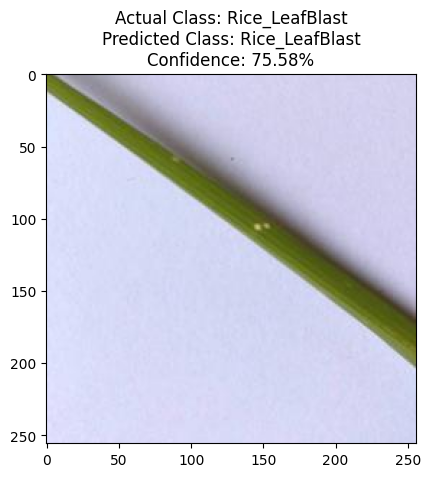

Actual Class: Rice_LeafBlast
Predicted Class: Rice_LeafBlast
Prediction Confidence: 75.58%


In [91]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

# Load the pre-trained model
model = load_model('Modelcrop/model_AlexNet.keras')

# Define the classes based on your training data
classes = list(train_generator.class_indices.keys())

# Function to preprocess the image
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))  
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  
    return img_array

# Load and preprocess the image
img_path = 'OneDrive/Desktop/images/validation/Rice_LeafBlast/shape 199 .jpg'
actual_class = 'Rice_LeafBlast'  # Specify the actual class here

preprocessed_image = preprocess_image(img_path)

# Predict the class of the image
prediction = model.predict(preprocessed_image)
predicted_class_index = np.argmax(prediction, axis=1)[0]
predicted_class = classes[predicted_class_index]

# Display the image along with the predicted and actual class
plt.imshow(image.load_img(img_path))
plt.title(f"Actual Class: {actual_class}\nPredicted Class: {predicted_class}\nConfidence: {prediction[0][predicted_class_index] * 100:.2f}%", fontsize=12)
plt.show()

print(f"Actual Class: {actual_class}")
print(f"Predicted Class: {predicted_class}")
print(f"Prediction Confidence: {prediction[0][predicted_class_index] * 100:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


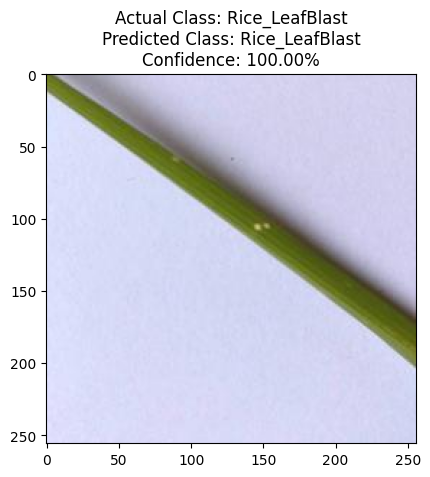

Actual Class: Rice_LeafBlast
Predicted Class: Rice_LeafBlast
Prediction Confidence: 100.00%


In [92]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

# Load the pre-trained model
model = load_model('Modelcrop/plant_disease_inception.keras')

# Define the classes based on your training data
classes = list(train_generator.class_indices.keys())

# Function to preprocess the image
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))  
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  
    return img_array

# Load and preprocess the image
img_path = 'OneDrive/Desktop/images/validation/Rice_LeafBlast/shape 199 .jpg'
actual_class = 'Rice_LeafBlast'  # Specify the actual class here

preprocessed_image = preprocess_image(img_path)

# Predict the class of the image
prediction = model.predict(preprocessed_image)
predicted_class_index = np.argmax(prediction, axis=1)[0]
predicted_class = classes[predicted_class_index]

# Display the image along with the predicted and actual class
plt.imshow(image.load_img(img_path))
plt.title(f"Actual Class: {actual_class}\nPredicted Class: {predicted_class}\nConfidence: {prediction[0][predicted_class_index] * 100:.2f}%", fontsize=12)
plt.show()

print(f"Actual Class: {actual_class}")
print(f"Predicted Class: {predicted_class}")
print(f"Prediction Confidence: {prediction[0][predicted_class_index] * 100:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


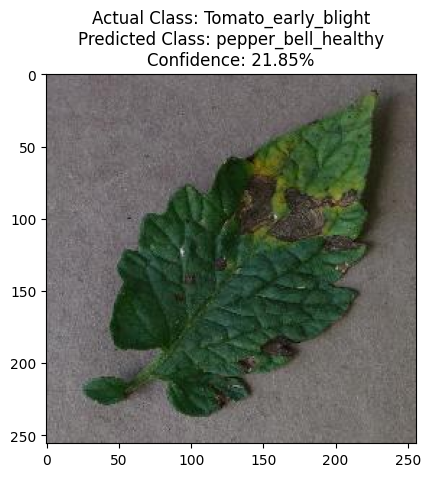

Actual Class: Tomato_early_blight
Predicted Class: pepper_bell_healthy
Prediction Confidence: 21.85%


In [100]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

# Load the pre-trained model
model = load_model('Modelcrop/plant_disease_Cnn.keras')

# Define the classes based on your training data
classes = list(train_generator.class_indices.keys())

# Function to preprocess the image
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))  
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  
    return img_array

# Load and preprocess the image
img_path = 'OneDrive/Desktop/images/validation/Tomato_early_blight/3726eff6-547d-411e-bc00-f8b533d067e3___RS_Erly.B 6494.JPG'
actual_class = 'Tomato_early_blight'  # Specify the actual class here

preprocessed_image = preprocess_image(img_path)

# Predict the class of the image
prediction = model.predict(preprocessed_image)
predicted_class_index = np.argmax(prediction, axis=1)[0]
predicted_class = classes[predicted_class_index]

# Display the image along with the predicted and actual class
plt.imshow(image.load_img(img_path))
plt.title(f"Actual Class: {actual_class}\nPredicted Class: {predicted_class}\nConfidence: {prediction[0][predicted_class_index] * 100:.2f}%", fontsize=12)
plt.show()

print(f"Actual Class: {actual_class}")
print(f"Predicted Class: {predicted_class}")
print(f"Prediction Confidence: {prediction[0][predicted_class_index] * 100:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step


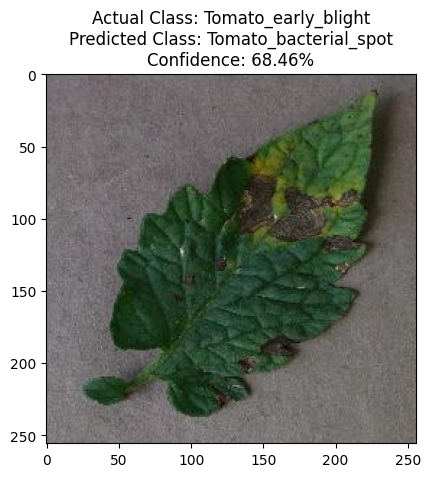

Actual Class: Tomato_early_blight
Predicted Class: Tomato_bacterial_spot
Prediction Confidence: 68.46%


In [99]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

# Load the pre-trained model
model = load_model('Modelcrop/plant_disease_VGG19.keras')

# Define the classes based on your training data
classes = list(train_generator.class_indices.keys())

# Function to preprocess the image
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))  
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  
    return img_array

# Load and preprocess the image
img_path = 'OneDrive/Desktop/images/validation/Tomato_early_blight/3726eff6-547d-411e-bc00-f8b533d067e3___RS_Erly.B 6494.JPG'
actual_class = 'Tomato_early_blight'  # Specify the actual class here

preprocessed_image = preprocess_image(img_path)

# Predict the class of the image
prediction = model.predict(preprocessed_image)
predicted_class_index = np.argmax(prediction, axis=1)[0]
predicted_class = classes[predicted_class_index]

# Display the image along with the predicted and actual class
plt.imshow(image.load_img(img_path))
plt.title(f"Actual Class: {actual_class}\nPredicted Class: {predicted_class}\nConfidence: {prediction[0][predicted_class_index] * 100:.2f}%", fontsize=12)
plt.show()

print(f"Actual Class: {actual_class}")
print(f"Predicted Class: {predicted_class}")
print(f"Prediction Confidence: {prediction[0][predicted_class_index] * 100:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


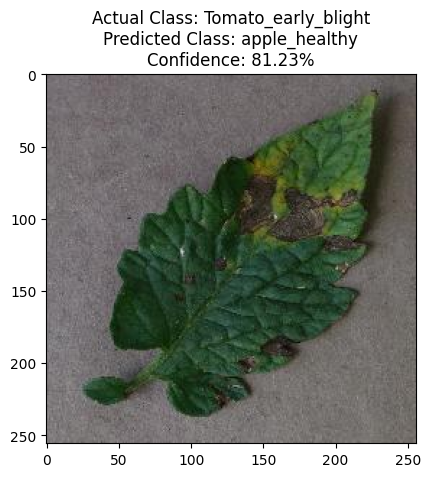

Actual Class: Tomato_early_blight
Predicted Class: apple_healthy
Prediction Confidence: 81.23%


In [101]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

# Load the pre-trained model
model = load_model('Modelcrop/model_AlexNet.keras')

# Define the classes based on your training data
classes = list(train_generator.class_indices.keys())

# Function to preprocess the image
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))  
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  
    return img_array

# Load and preprocess the image
img_path = 'OneDrive/Desktop/images/validation/Tomato_early_blight/3726eff6-547d-411e-bc00-f8b533d067e3___RS_Erly.B 6494.JPG'
actual_class = 'Tomato_early_blight'  # Specify the actual class here

preprocessed_image = preprocess_image(img_path)

# Predict the class of the image
prediction = model.predict(preprocessed_image)
predicted_class_index = np.argmax(prediction, axis=1)[0]
predicted_class = classes[predicted_class_index]

# Display the image along with the predicted and actual class
plt.imshow(image.load_img(img_path))
plt.title(f"Actual Class: {actual_class}\nPredicted Class: {predicted_class}\nConfidence: {prediction[0][predicted_class_index] * 100:.2f}%", fontsize=12)
plt.show()

print(f"Actual Class: {actual_class}")
print(f"Predicted Class: {predicted_class}")
print(f"Prediction Confidence: {prediction[0][predicted_class_index] * 100:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


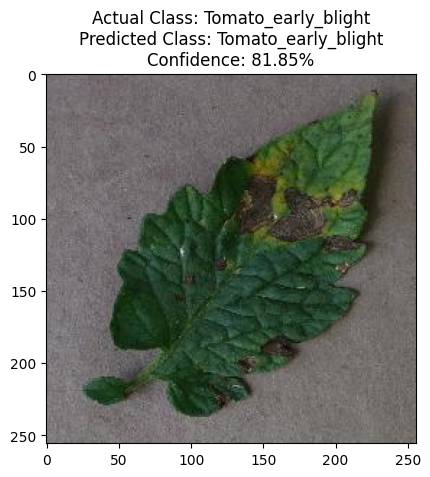

Actual Class: Tomato_early_blight
Predicted Class: Tomato_early_blight
Prediction Confidence: 81.85%


In [102]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

# Load the pre-trained model
model = load_model('Modelcrop/plant_disease_inception.keras')

# Define the classes based on your training data
classes = list(train_generator.class_indices.keys())

# Function to preprocess the image
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))  
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  
    return img_array

# Load and preprocess the image
img_path = 'OneDrive/Desktop/images/validation/Tomato_early_blight/3726eff6-547d-411e-bc00-f8b533d067e3___RS_Erly.B 6494.JPG'
actual_class = 'Tomato_early_blight'  # Specify the actual class here

preprocessed_image = preprocess_image(img_path)

# Predict the class of the image
prediction = model.predict(preprocessed_image)
predicted_class_index = np.argmax(prediction, axis=1)[0]
predicted_class = classes[predicted_class_index]

# Display the image along with the predicted and actual class
plt.imshow(image.load_img(img_path))
plt.title(f"Actual Class: {actual_class}\nPredicted Class: {predicted_class}\nConfidence: {prediction[0][predicted_class_index] * 100:.2f}%", fontsize=12)
plt.show()

print(f"Actual Class: {actual_class}")
print(f"Predicted Class: {predicted_class}")
print(f"Prediction Confidence: {prediction[0][predicted_class_index] * 100:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


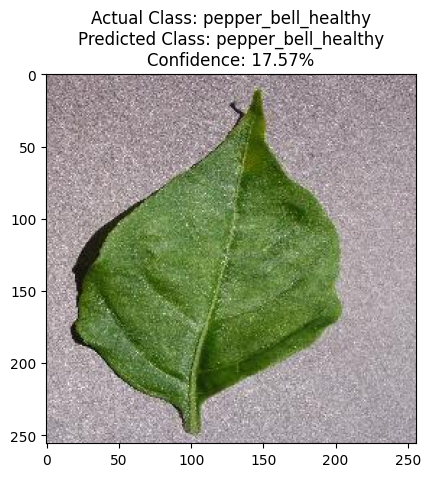

Actual Class: pepper_bell_healthy
Predicted Class: pepper_bell_healthy
Prediction Confidence: 17.57%


In [108]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

# Load the pre-trained model
model = load_model('Modelcrop/plant_disease_Cnn.keras')

# Define the classes based on your training data
classes = list(train_generator.class_indices.keys())

# Function to preprocess the image
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))  
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  
    return img_array

# Load and preprocess the image
#img_path = 'OneDrive/Desktop/images/validation/pepper_bell_healthy/1c2515f2-c0a7-455e-bc5d-649037cb6e3e___JR_HL 7634.JPG'
img_path ='OneDrive/Desktop/images/validation/pepper_bell_healthy/26605bb8-e0b1-4232-b4bb-a4aba0b47edd___JR_HL 8777.JPG'
actual_class = 'pepper_bell_healthy'  # Specify the actual class here

preprocessed_image = preprocess_image(img_path)

# Predict the class of the image
prediction = model.predict(preprocessed_image)
predicted_class_index = np.argmax(prediction, axis=1)[0]
predicted_class = classes[predicted_class_index]

# Display the image along with the predicted and actual class
plt.imshow(image.load_img(img_path))
plt.title(f"Actual Class: {actual_class}\nPredicted Class: {predicted_class}\nConfidence: {prediction[0][predicted_class_index] * 100:.2f}%", fontsize=12)
plt.show()

print(f"Actual Class: {actual_class}")
print(f"Predicted Class: {predicted_class}")
print(f"Prediction Confidence: {prediction[0][predicted_class_index] * 100:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step


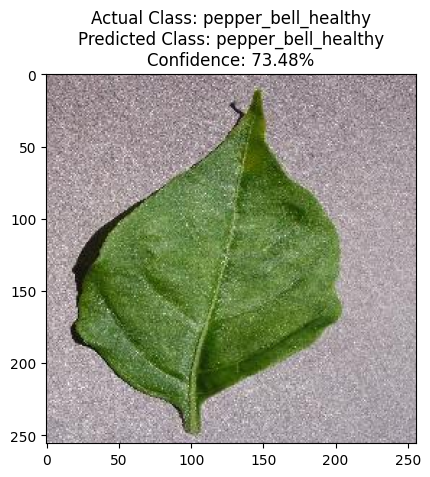

Actual Class: pepper_bell_healthy
Predicted Class: pepper_bell_healthy
Prediction Confidence: 73.48%


In [109]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

# Load the pre-trained model
model = load_model('Modelcrop/plant_disease_VGG19.keras')

# Define the classes based on your training data
classes = list(train_generator.class_indices.keys())

# Function to preprocess the image
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))  
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  
    return img_array

# Load and preprocess the image
#img_path = 'OneDrive/Desktop/images/validation/pepper_bell_healthy/1c2515f2-c0a7-455e-bc5d-649037cb6e3e___JR_HL 7634.JPG'
img_path ='OneDrive/Desktop/images/validation/pepper_bell_healthy/26605bb8-e0b1-4232-b4bb-a4aba0b47edd___JR_HL 8777.JPG'
actual_class = 'pepper_bell_healthy'  # Specify the actual class here

preprocessed_image = preprocess_image(img_path)

# Predict the class of the image
prediction = model.predict(preprocessed_image)
predicted_class_index = np.argmax(prediction, axis=1)[0]
predicted_class = classes[predicted_class_index]

# Display the image along with the predicted and actual class
plt.imshow(image.load_img(img_path))
plt.title(f"Actual Class: {actual_class}\nPredicted Class: {predicted_class}\nConfidence: {prediction[0][predicted_class_index] * 100:.2f}%", fontsize=12)
plt.show()

print(f"Actual Class: {actual_class}")
print(f"Predicted Class: {predicted_class}")
print(f"Prediction Confidence: {prediction[0][predicted_class_index] * 100:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


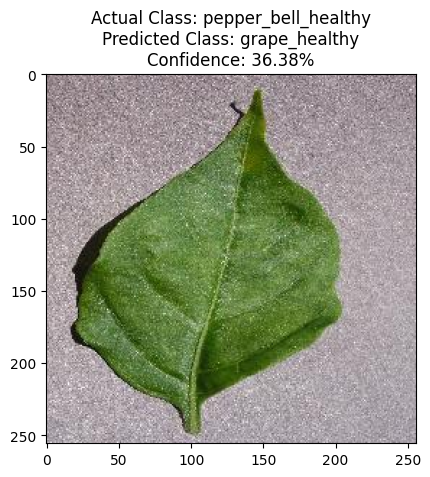

Actual Class: pepper_bell_healthy
Predicted Class: grape_healthy
Prediction Confidence: 36.38%


In [110]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

# Load the pre-trained model
model = load_model('Modelcrop/model_AlexNet.keras')

# Define the classes based on your training data
classes = list(train_generator.class_indices.keys())

# Function to preprocess the image
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))  
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  
    return img_array

# Load and preprocess the image
#img_path = 'OneDrive/Desktop/images/validation/pepper_bell_healthy/1c2515f2-c0a7-455e-bc5d-649037cb6e3e___JR_HL 7634.JPG'
img_path ='OneDrive/Desktop/images/validation/pepper_bell_healthy/26605bb8-e0b1-4232-b4bb-a4aba0b47edd___JR_HL 8777.JPG'
actual_class = 'pepper_bell_healthy'  # Specify the actual class here

preprocessed_image = preprocess_image(img_path)

# Predict the class of the image
prediction = model.predict(preprocessed_image)
predicted_class_index = np.argmax(prediction, axis=1)[0]
predicted_class = classes[predicted_class_index]

# Display the image along with the predicted and actual class
plt.imshow(image.load_img(img_path))
plt.title(f"Actual Class: {actual_class}\nPredicted Class: {predicted_class}\nConfidence: {prediction[0][predicted_class_index] * 100:.2f}%", fontsize=12)
plt.show()

print(f"Actual Class: {actual_class}")
print(f"Predicted Class: {predicted_class}")
print(f"Prediction Confidence: {prediction[0][predicted_class_index] * 100:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


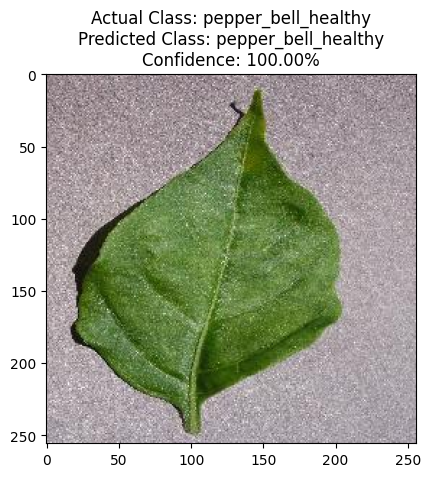

Actual Class: pepper_bell_healthy
Predicted Class: pepper_bell_healthy
Prediction Confidence: 100.00%


In [111]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

# Load the pre-trained model
model = load_model('Modelcrop/plant_disease_inception.keras')

# Define the classes based on your training data
classes = list(train_generator.class_indices.keys())

# Function to preprocess the image
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))  
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  
    return img_array

# Load and preprocess the image
#img_path = 'OneDrive/Desktop/images/validation/pepper_bell_healthy/1c2515f2-c0a7-455e-bc5d-649037cb6e3e___JR_HL 7634.JPG'
img_path ='OneDrive/Desktop/images/validation/pepper_bell_healthy/26605bb8-e0b1-4232-b4bb-a4aba0b47edd___JR_HL 8777.JPG'
actual_class = 'pepper_bell_healthy'  # Specify the actual class here

preprocessed_image = preprocess_image(img_path)

# Predict the class of the image
prediction = model.predict(preprocessed_image)
predicted_class_index = np.argmax(prediction, axis=1)[0]
predicted_class = classes[predicted_class_index]

# Display the image along with the predicted and actual class
plt.imshow(image.load_img(img_path))
plt.title(f"Actual Class: {actual_class}\nPredicted Class: {predicted_class}\nConfidence: {prediction[0][predicted_class_index] * 100:.2f}%", fontsize=12)
plt.show()

print(f"Actual Class: {actual_class}")
print(f"Predicted Class: {predicted_class}")
print(f"Prediction Confidence: {prediction[0][predicted_class_index] * 100:.2f}%")